# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)

Found mnist Data


In [2]:
helper.download_extract('celeba', data_dir)

Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

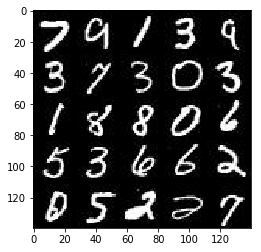

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

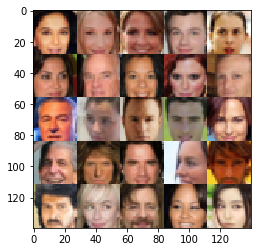

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_image = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_image') 
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z') 
    learning_rate = tf.placeholder(tf.float32, name='learning_rate') 
    
    return input_image, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [30]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28x3
        conv1 = tf.layers.conv2d(images, 32, 3, strides=2, padding='same')
        lrelu1 = tf.maximum(alpha*conv1, conv1)
        # 14x14x32
        
        conv2 = tf.layers.conv2d(lrelu1, 64, 3, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha*bn2, bn2)
        # 7x7x64
        
        conv3 = tf.layers.conv2d(lrelu2, 128, 3, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha*bn3, bn3)
        # 4x4x128
        
        flat = tf.reshape(lrelu3, (-1, 4*4*128))
        # flat = tf.reduce_mean(lrelu3, (1, 2))  
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [31]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(x2, rate=0.5)
        # 7x7x256

        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x3, rate=0.5)
        # 7x7x128
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 3, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 14x14x64
        
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, strides=2, padding='same')
        # 28x28xout_channel_dim
        
        # logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        #
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [32]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [33]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [34]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [37]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # tf.reset_default_graph()
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model

                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 50 == 0:
                    # every 50 steps, print losses
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g),
                          "Sum Loss: {:.4f}".format(train_loss_g+train_loss_d))
                
                if steps % 200 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.5694... Generator Loss: 1.8723 Sum Loss: 3.4418
Epoch 1/2... Discriminator Loss: 1.0235... Generator Loss: 0.6534 Sum Loss: 1.6769
Epoch 1/2... Discriminator Loss: 0.3841... Generator Loss: 2.5108 Sum Loss: 2.8948
Epoch 1/2... Discriminator Loss: 0.7684... Generator Loss: 0.9999 Sum Loss: 1.7682


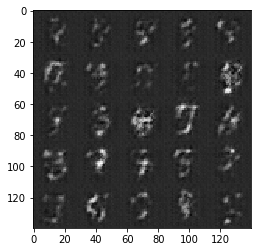

Epoch 1/2... Discriminator Loss: 0.3553... Generator Loss: 1.5530 Sum Loss: 1.9083
Epoch 1/2... Discriminator Loss: 0.3244... Generator Loss: 1.5470 Sum Loss: 1.8714
Epoch 1/2... Discriminator Loss: 0.0883... Generator Loss: 3.3713 Sum Loss: 3.4596
Epoch 1/2... Discriminator Loss: 1.1376... Generator Loss: 0.5984 Sum Loss: 1.7360


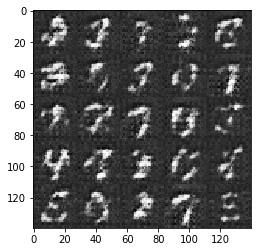

Epoch 1/2... Discriminator Loss: 1.3856... Generator Loss: 0.3921 Sum Loss: 1.7777
Epoch 1/2... Discriminator Loss: 0.3889... Generator Loss: 1.3993 Sum Loss: 1.7882
Epoch 1/2... Discriminator Loss: 1.1091... Generator Loss: 0.7050 Sum Loss: 1.8142
Epoch 1/2... Discriminator Loss: 0.2516... Generator Loss: 1.8685 Sum Loss: 2.1201


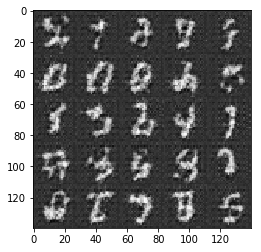

Epoch 1/2... Discriminator Loss: 0.0394... Generator Loss: 5.0765 Sum Loss: 5.1159
Epoch 1/2... Discriminator Loss: 1.0012... Generator Loss: 1.0224 Sum Loss: 2.0237
Epoch 1/2... Discriminator Loss: 0.7434... Generator Loss: 2.1856 Sum Loss: 2.9290
Epoch 1/2... Discriminator Loss: 0.1535... Generator Loss: 3.0811 Sum Loss: 3.2346


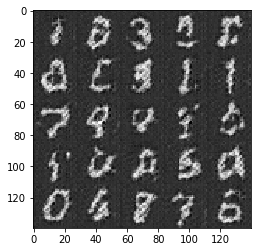

Epoch 1/2... Discriminator Loss: 0.1381... Generator Loss: 2.6126 Sum Loss: 2.7507
Epoch 1/2... Discriminator Loss: 0.7411... Generator Loss: 2.1248 Sum Loss: 2.8659
Epoch 1/2... Discriminator Loss: 0.3592... Generator Loss: 1.8240 Sum Loss: 2.1832
Epoch 1/2... Discriminator Loss: 0.2443... Generator Loss: 1.8202 Sum Loss: 2.0644


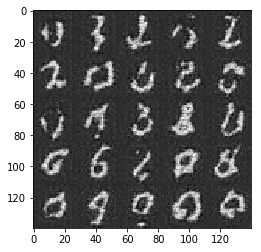

Epoch 1/2... Discriminator Loss: 0.6983... Generator Loss: 1.6249 Sum Loss: 2.3232
Epoch 1/2... Discriminator Loss: 2.1114... Generator Loss: 0.1782 Sum Loss: 2.2897
Epoch 1/2... Discriminator Loss: 0.5558... Generator Loss: 1.0747 Sum Loss: 1.6305
Epoch 1/2... Discriminator Loss: 0.1458... Generator Loss: 2.3356 Sum Loss: 2.4814


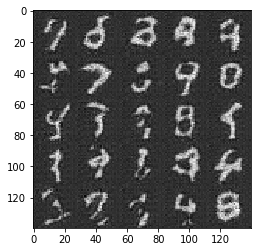

Epoch 1/2... Discriminator Loss: 0.1706... Generator Loss: 2.5451 Sum Loss: 2.7158
Epoch 1/2... Discriminator Loss: 0.5955... Generator Loss: 1.4183 Sum Loss: 2.0138
Epoch 1/2... Discriminator Loss: 1.6491... Generator Loss: 0.2874 Sum Loss: 1.9365
Epoch 1/2... Discriminator Loss: 0.5537... Generator Loss: 1.2662 Sum Loss: 1.8199


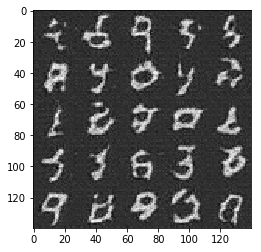

Epoch 1/2... Discriminator Loss: 0.2086... Generator Loss: 2.2603 Sum Loss: 2.4690
Epoch 1/2... Discriminator Loss: 0.1630... Generator Loss: 2.2220 Sum Loss: 2.3851
Epoch 1/2... Discriminator Loss: 0.7841... Generator Loss: 0.8678 Sum Loss: 1.6520
Epoch 1/2... Discriminator Loss: 0.7527... Generator Loss: 0.7545 Sum Loss: 1.5072


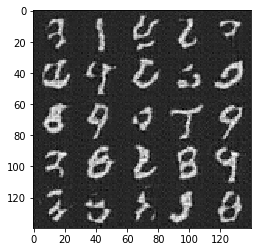

Epoch 1/2... Discriminator Loss: 1.7350... Generator Loss: 0.2626 Sum Loss: 1.9976
Epoch 1/2... Discriminator Loss: 1.1419... Generator Loss: 0.4893 Sum Loss: 1.6312
Epoch 1/2... Discriminator Loss: 0.4810... Generator Loss: 1.6665 Sum Loss: 2.1476
Epoch 1/2... Discriminator Loss: 0.4696... Generator Loss: 1.3239 Sum Loss: 1.7935


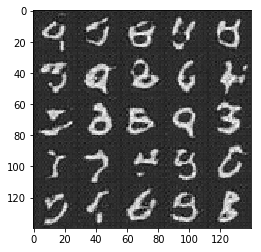

Epoch 1/2... Discriminator Loss: 1.2336... Generator Loss: 1.7693 Sum Loss: 3.0029
Epoch 2/2... Discriminator Loss: 0.4521... Generator Loss: 1.4193 Sum Loss: 1.8714
Epoch 2/2... Discriminator Loss: 1.0367... Generator Loss: 0.6481 Sum Loss: 1.6848
Epoch 2/2... Discriminator Loss: 0.7738... Generator Loss: 0.8211 Sum Loss: 1.5950


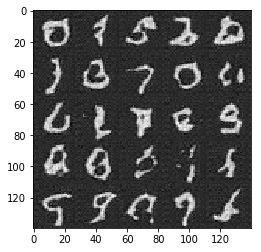

Epoch 2/2... Discriminator Loss: 0.5413... Generator Loss: 1.1230 Sum Loss: 1.6642
Epoch 2/2... Discriminator Loss: 0.7863... Generator Loss: 0.7695 Sum Loss: 1.5558
Epoch 2/2... Discriminator Loss: 0.2578... Generator Loss: 2.0337 Sum Loss: 2.2915
Epoch 2/2... Discriminator Loss: 0.5367... Generator Loss: 1.1337 Sum Loss: 1.6704


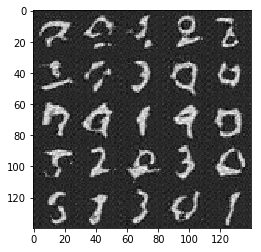

Epoch 2/2... Discriminator Loss: 0.3744... Generator Loss: 1.5804 Sum Loss: 1.9548
Epoch 2/2... Discriminator Loss: 0.1744... Generator Loss: 2.3659 Sum Loss: 2.5403
Epoch 2/2... Discriminator Loss: 0.4773... Generator Loss: 2.1670 Sum Loss: 2.6443
Epoch 2/2... Discriminator Loss: 1.5140... Generator Loss: 0.3513 Sum Loss: 1.8653


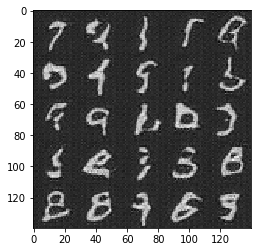

Epoch 2/2... Discriminator Loss: 1.0030... Generator Loss: 0.6735 Sum Loss: 1.6765
Epoch 2/2... Discriminator Loss: 0.2454... Generator Loss: 1.9692 Sum Loss: 2.2146
Epoch 2/2... Discriminator Loss: 0.1679... Generator Loss: 2.3899 Sum Loss: 2.5578
Epoch 2/2... Discriminator Loss: 1.7808... Generator Loss: 3.8557 Sum Loss: 5.6365


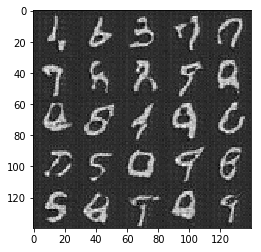

Epoch 2/2... Discriminator Loss: 2.0122... Generator Loss: 0.1939 Sum Loss: 2.2061
Epoch 2/2... Discriminator Loss: 1.9184... Generator Loss: 0.6354 Sum Loss: 2.5538
Epoch 2/2... Discriminator Loss: 0.7792... Generator Loss: 0.8501 Sum Loss: 1.6293
Epoch 2/2... Discriminator Loss: 0.2672... Generator Loss: 2.2917 Sum Loss: 2.5588


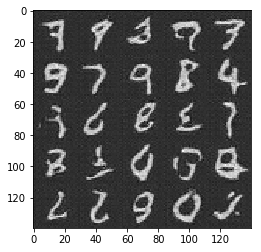

Epoch 2/2... Discriminator Loss: 0.1646... Generator Loss: 4.2928 Sum Loss: 4.4574
Epoch 2/2... Discriminator Loss: 0.7059... Generator Loss: 1.0521 Sum Loss: 1.7580
Epoch 2/2... Discriminator Loss: 0.1465... Generator Loss: 2.6822 Sum Loss: 2.8287
Epoch 2/2... Discriminator Loss: 0.5557... Generator Loss: 1.1658 Sum Loss: 1.7216


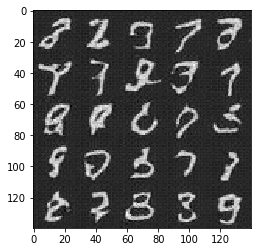

Epoch 2/2... Discriminator Loss: 1.8723... Generator Loss: 3.4128 Sum Loss: 5.2851
Epoch 2/2... Discriminator Loss: 0.3617... Generator Loss: 1.4553 Sum Loss: 1.8170
Epoch 2/2... Discriminator Loss: 0.8902... Generator Loss: 0.7652 Sum Loss: 1.6553
Epoch 2/2... Discriminator Loss: 1.1668... Generator Loss: 0.5905 Sum Loss: 1.7573


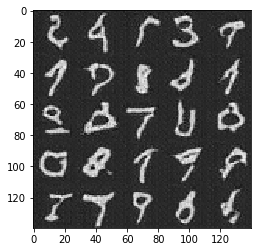

Epoch 2/2... Discriminator Loss: 0.5694... Generator Loss: 1.9043 Sum Loss: 2.4738
Epoch 2/2... Discriminator Loss: 0.6312... Generator Loss: 0.9821 Sum Loss: 1.6133
Epoch 2/2... Discriminator Loss: 0.2791... Generator Loss: 2.3402 Sum Loss: 2.6193
Epoch 2/2... Discriminator Loss: 0.0499... Generator Loss: 4.0862 Sum Loss: 4.1360


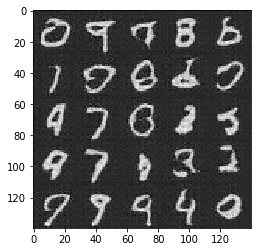

Epoch 2/2... Discriminator Loss: 1.3743... Generator Loss: 0.4262 Sum Loss: 1.8006
Epoch 2/2... Discriminator Loss: 0.3547... Generator Loss: 1.6695 Sum Loss: 2.0243
Epoch 2/2... Discriminator Loss: 0.5123... Generator Loss: 1.2120 Sum Loss: 1.7243
Epoch 2/2... Discriminator Loss: 1.9650... Generator Loss: 4.9149 Sum Loss: 6.8799


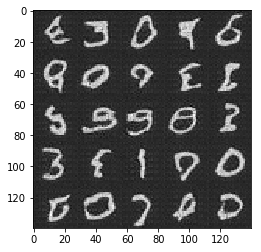

Epoch 2/2... Discriminator Loss: 0.9734... Generator Loss: 0.6635 Sum Loss: 1.6369
Epoch 2/2... Discriminator Loss: 0.9615... Generator Loss: 0.6709 Sum Loss: 1.6324
Epoch 2/2... Discriminator Loss: 0.4308... Generator Loss: 2.6550 Sum Loss: 3.0858


In [38]:
batch_size = 32
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.8462... Generator Loss: 0.2220 Sum Loss: 2.0682
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.5755 Sum Loss: 1.8716
Epoch 1/1... Discriminator Loss: 1.5883... Generator Loss: 0.3572 Sum Loss: 1.9456
Epoch 1/1... Discriminator Loss: 0.2098... Generator Loss: 5.1275 Sum Loss: 5.3373


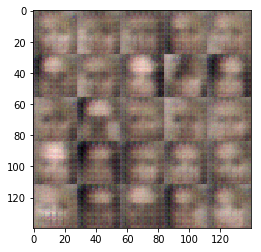

Epoch 1/1... Discriminator Loss: 0.3027... Generator Loss: 2.3880 Sum Loss: 2.6907
Epoch 1/1... Discriminator Loss: 0.3878... Generator Loss: 1.7002 Sum Loss: 2.0880
Epoch 1/1... Discriminator Loss: 0.3303... Generator Loss: 5.3839 Sum Loss: 5.7141
Epoch 1/1... Discriminator Loss: 1.7727... Generator Loss: 2.7849 Sum Loss: 4.5576


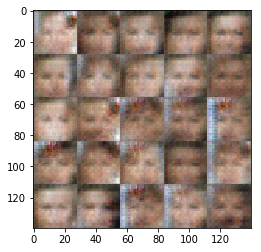

Epoch 1/1... Discriminator Loss: 0.3001... Generator Loss: 5.3580 Sum Loss: 5.6581
Epoch 1/1... Discriminator Loss: 0.1378... Generator Loss: 2.9942 Sum Loss: 3.1320
Epoch 1/1... Discriminator Loss: 0.5963... Generator Loss: 1.5387 Sum Loss: 2.1349
Epoch 1/1... Discriminator Loss: 0.6723... Generator Loss: 1.0469 Sum Loss: 1.7193


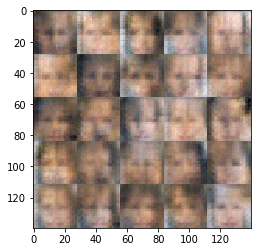

Epoch 1/1... Discriminator Loss: 0.3382... Generator Loss: 2.3933 Sum Loss: 2.7315
Epoch 1/1... Discriminator Loss: 1.5635... Generator Loss: 0.5473 Sum Loss: 2.1109
Epoch 1/1... Discriminator Loss: 0.3522... Generator Loss: 2.5913 Sum Loss: 2.9435
Epoch 1/1... Discriminator Loss: 0.5661... Generator Loss: 3.0036 Sum Loss: 3.5698


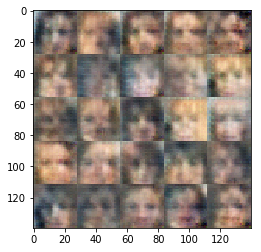

Epoch 1/1... Discriminator Loss: 1.0439... Generator Loss: 4.3594 Sum Loss: 5.4033
Epoch 1/1... Discriminator Loss: 0.7095... Generator Loss: 1.0397 Sum Loss: 1.7492
Epoch 1/1... Discriminator Loss: 0.3581... Generator Loss: 2.9306 Sum Loss: 3.2887
Epoch 1/1... Discriminator Loss: 1.6595... Generator Loss: 0.3015 Sum Loss: 1.9610


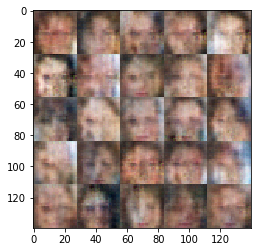

Epoch 1/1... Discriminator Loss: 0.0474... Generator Loss: 6.3681 Sum Loss: 6.4155
Epoch 1/1... Discriminator Loss: 1.7467... Generator Loss: 0.4749 Sum Loss: 2.2216
Epoch 1/1... Discriminator Loss: 0.2460... Generator Loss: 5.4951 Sum Loss: 5.7411
Epoch 1/1... Discriminator Loss: 0.6738... Generator Loss: 1.0010 Sum Loss: 1.6749


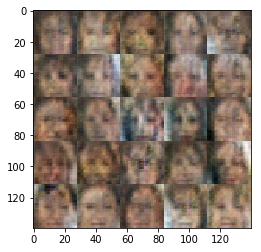

Epoch 1/1... Discriminator Loss: 0.2154... Generator Loss: 3.2593 Sum Loss: 3.4747
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 0.7572 Sum Loss: 1.7925
Epoch 1/1... Discriminator Loss: 0.3146... Generator Loss: 2.3988 Sum Loss: 2.7134
Epoch 1/1... Discriminator Loss: 0.4562... Generator Loss: 1.8921 Sum Loss: 2.3482


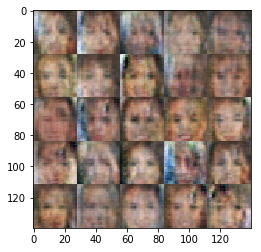

Epoch 1/1... Discriminator Loss: 0.8410... Generator Loss: 1.7303 Sum Loss: 2.5713
Epoch 1/1... Discriminator Loss: 0.4129... Generator Loss: 4.5387 Sum Loss: 4.9516
Epoch 1/1... Discriminator Loss: 0.4627... Generator Loss: 2.6887 Sum Loss: 3.1515
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.4229 Sum Loss: 1.7015


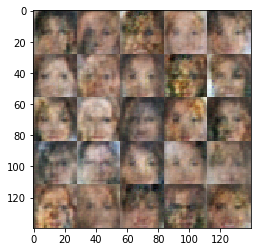

Epoch 1/1... Discriminator Loss: 0.3453... Generator Loss: 1.9543 Sum Loss: 2.2996
Epoch 1/1... Discriminator Loss: 0.6986... Generator Loss: 1.8796 Sum Loss: 2.5783
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.3658 Sum Loss: 1.8197
Epoch 1/1... Discriminator Loss: 2.1078... Generator Loss: 0.6346 Sum Loss: 2.7424


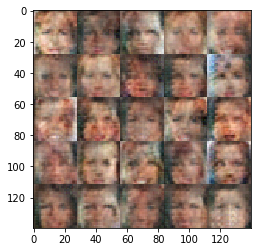

Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.6806 Sum Loss: 1.9727
Epoch 1/1... Discriminator Loss: 1.6504... Generator Loss: 0.5794 Sum Loss: 2.2298
Epoch 1/1... Discriminator Loss: 0.5830... Generator Loss: 1.3541 Sum Loss: 1.9370
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 0.8270 Sum Loss: 1.8375


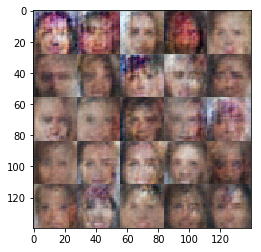

Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 0.6729 Sum Loss: 1.6778
Epoch 1/1... Discriminator Loss: 2.5279... Generator Loss: 0.0982 Sum Loss: 2.6261
Epoch 1/1... Discriminator Loss: 2.1500... Generator Loss: 0.6676 Sum Loss: 2.8176
Epoch 1/1... Discriminator Loss: 0.5619... Generator Loss: 1.5441 Sum Loss: 2.1060


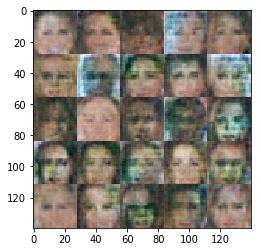

Epoch 1/1... Discriminator Loss: 2.4834... Generator Loss: 0.2807 Sum Loss: 2.7641
Epoch 1/1... Discriminator Loss: 0.1110... Generator Loss: 3.0437 Sum Loss: 3.1547
Epoch 1/1... Discriminator Loss: 0.7850... Generator Loss: 0.8205 Sum Loss: 1.6055
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.5276 Sum Loss: 1.7882


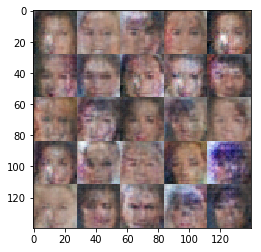

Epoch 1/1... Discriminator Loss: 2.6853... Generator Loss: 0.5236 Sum Loss: 3.2089
Epoch 1/1... Discriminator Loss: 0.5181... Generator Loss: 3.6457 Sum Loss: 4.1638
Epoch 1/1... Discriminator Loss: 0.8189... Generator Loss: 0.7956 Sum Loss: 1.6145
Epoch 1/1... Discriminator Loss: 1.5549... Generator Loss: 1.4458 Sum Loss: 3.0007


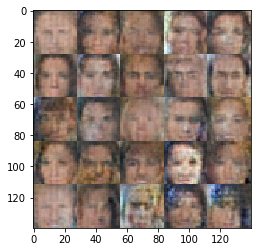

Epoch 1/1... Discriminator Loss: 0.2106... Generator Loss: 2.9434 Sum Loss: 3.1540
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 2.4470 Sum Loss: 3.6226
Epoch 1/1... Discriminator Loss: 0.5471... Generator Loss: 1.5275 Sum Loss: 2.0745
Epoch 1/1... Discriminator Loss: 0.3834... Generator Loss: 2.8276 Sum Loss: 3.2110


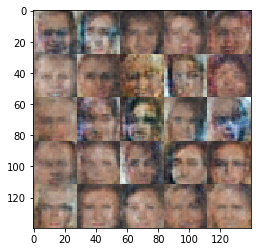

Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.3557 Sum Loss: 1.8202
Epoch 1/1... Discriminator Loss: 1.6934... Generator Loss: 0.8878 Sum Loss: 2.5812
Epoch 1/1... Discriminator Loss: 1.5411... Generator Loss: 0.3724 Sum Loss: 1.9135
Epoch 1/1... Discriminator Loss: 1.4981... Generator Loss: 0.5970 Sum Loss: 2.0951


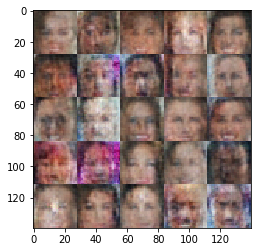

Epoch 1/1... Discriminator Loss: 1.8169... Generator Loss: 0.9027 Sum Loss: 2.7196
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.5971 Sum Loss: 1.8395
Epoch 1/1... Discriminator Loss: 2.1747... Generator Loss: 0.1660 Sum Loss: 2.3407
Epoch 1/1... Discriminator Loss: 0.1656... Generator Loss: 2.4712 Sum Loss: 2.6367


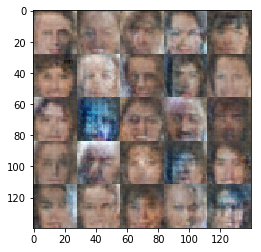

Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.8056 Sum Loss: 2.1869
Epoch 1/1... Discriminator Loss: 1.6756... Generator Loss: 1.4791 Sum Loss: 3.1547
Epoch 1/1... Discriminator Loss: 0.8034... Generator Loss: 2.0360 Sum Loss: 2.8394
Epoch 1/1... Discriminator Loss: 0.6592... Generator Loss: 1.9633 Sum Loss: 2.6225


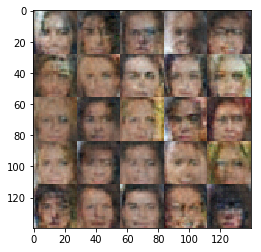

Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.4667 Sum Loss: 1.8566
Epoch 1/1... Discriminator Loss: 1.9060... Generator Loss: 0.3881 Sum Loss: 2.2942
Epoch 1/1... Discriminator Loss: 1.5661... Generator Loss: 0.4210 Sum Loss: 1.9871
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.7278 Sum Loss: 2.0570


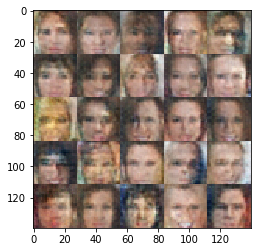

Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.4964 Sum Loss: 1.8739
Epoch 1/1... Discriminator Loss: 1.7797... Generator Loss: 0.4464 Sum Loss: 2.2261
Epoch 1/1... Discriminator Loss: 0.9655... Generator Loss: 0.9340 Sum Loss: 1.8995
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.6228 Sum Loss: 2.0754


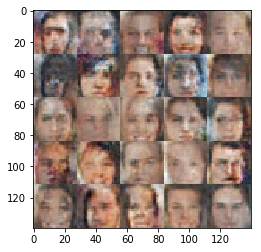

Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.5417 Sum Loss: 1.8972
Epoch 1/1... Discriminator Loss: 1.4811... Generator Loss: 0.4867 Sum Loss: 1.9678
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.6491 Sum Loss: 2.0133
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.5847 Sum Loss: 1.8483


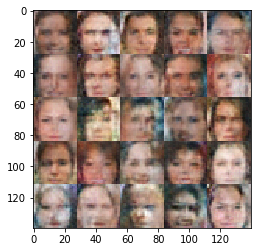

Epoch 1/1... Discriminator Loss: 1.5014... Generator Loss: 0.5163 Sum Loss: 2.0177
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.6538 Sum Loss: 2.0128
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.4876 Sum Loss: 1.9591
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.6980 Sum Loss: 2.0138


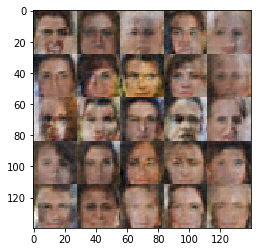

Epoch 1/1... Discriminator Loss: 1.8228... Generator Loss: 0.3984 Sum Loss: 2.2212
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.5862 Sum Loss: 1.9767
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6582 Sum Loss: 2.0447
Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 0.4420 Sum Loss: 1.9485


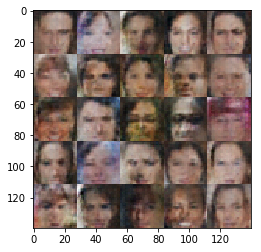

Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.4203 Sum Loss: 1.9283
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.4880 Sum Loss: 1.9644
Epoch 1/1... Discriminator Loss: 1.5357... Generator Loss: 0.5295 Sum Loss: 2.0651
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.5730 Sum Loss: 2.0113


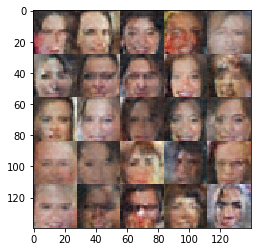

Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.6838 Sum Loss: 2.1030
Epoch 1/1... Discriminator Loss: 1.5023... Generator Loss: 0.6401 Sum Loss: 2.1425
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.5775 Sum Loss: 1.9716
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.9046 Sum Loss: 2.2817


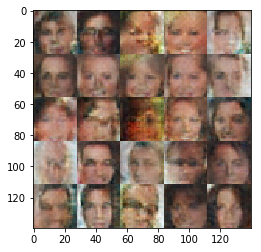

Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.5318 Sum Loss: 1.9791
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.6217 Sum Loss: 1.8681
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.5333 Sum Loss: 2.0064
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.6736 Sum Loss: 2.0202


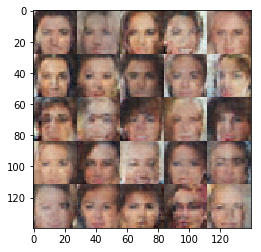

Epoch 1/1... Discriminator Loss: 1.8341... Generator Loss: 0.4096 Sum Loss: 2.2437
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7233 Sum Loss: 2.1313
Epoch 1/1... Discriminator Loss: 1.5172... Generator Loss: 0.4674 Sum Loss: 1.9846
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.7249 Sum Loss: 1.9881


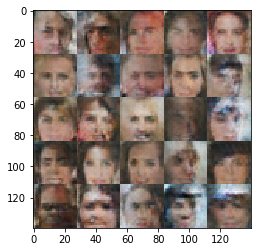

Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.5516 Sum Loss: 1.9906
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.5685 Sum Loss: 2.0537
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.6158 Sum Loss: 1.9186
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.6300 Sum Loss: 2.0486


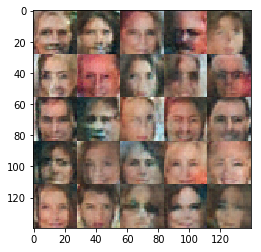

Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.6617 Sum Loss: 2.0552
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.6591 Sum Loss: 2.0212
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.4431 Sum Loss: 1.9217
Epoch 1/1... Discriminator Loss: 1.6205... Generator Loss: 0.4657 Sum Loss: 2.0862


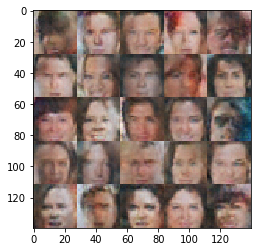

Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.5255 Sum Loss: 1.8856
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.6597 Sum Loss: 1.9148
Epoch 1/1... Discriminator Loss: 1.5019... Generator Loss: 0.5494 Sum Loss: 2.0513
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.7006 Sum Loss: 2.0025


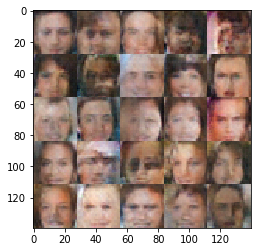

Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.5120 Sum Loss: 2.0220
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.5368 Sum Loss: 2.0124
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.6448 Sum Loss: 1.9419
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.6279 Sum Loss: 1.9819


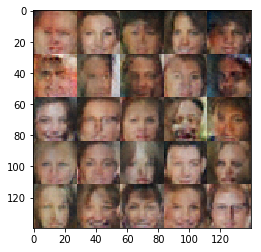

Epoch 1/1... Discriminator Loss: 1.5970... Generator Loss: 0.4503 Sum Loss: 2.0473
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7214 Sum Loss: 2.1542
Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.4771 Sum Loss: 1.9410
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.5647 Sum Loss: 2.0350


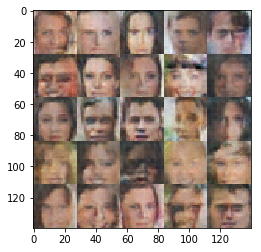

Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.5300 Sum Loss: 1.9506
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.5561 Sum Loss: 2.0344


In [39]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.